## 🔹 Paso 0: Preparación

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


## 🔹 Paso 1: Carga del Dataset

In [2]:

# Reemplaza con tu archivo/dataset
data = pd.read_csv("../1_data/dataset_obesity_clean.csv", index_col=0)
display(data.head())


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
data.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

## 🔹 Paso 2: Preprocesamiento de Datos

In [4]:

categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('NObeyesdad')
data_encoded = pd.get_dummies(data, columns=categorical_cols, dummy_na=False) # cambia variables categoricas a numericas
df_processed = data_encoded.copy()
df_processed.head()


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Female,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,Normal_Weight,True,...,False,False,False,False,True,False,False,False,True,False
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,Normal_Weight,True,...,True,False,False,True,False,False,False,False,True,False
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,Normal_Weight,False,...,False,False,True,False,False,False,False,False,True,False
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,Overweight_Level_I,False,...,False,False,True,False,False,False,False,False,False,True
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,Overweight_Level_II,False,...,False,False,False,True,False,False,False,False,True,False


In [5]:
df_processed.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'NObeyesdad', 'Gender_Female', 'Gender_Male',
       'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
       'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
       'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
       'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
       'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')

## 🔹 Paso 3: Ingeniería de Características

In [6]:

df_processed['BMI'] = df_processed['Weight'] / (df_processed['Height'] ** 2)

X = df_processed.drop(columns=['NObeyesdad'])
y = df_processed['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
importance_df.sort_values(by='importance', ascending=False).head(20)


,feature,importance
31,BMI,0.323169
2,Weight,0.179640
0,Age,0.057949
3,FCVC,0.057595
1,Height,0.051101
8,Gender_Female,0.038305
4,NCP,0.036130
9,Gender_Male,0.031118
7,TUE,0.027389
5,CH2O,0.025054


## 🔹 Paso 4: Nuevas Características Basadas en Importancia

In [7]:

df_processed['Weight_Age_Ratio'] = df_processed['Weight'] / df_processed['Age']
df_processed['FAF_TUE_Interaction'] = df_processed['FAF'] * df_processed['TUE']


## 🔹 Paso 5: División del Dataset (Train/Val/Test)

In [8]:

X = df_processed.drop(columns=['NObeyesdad'])
y = df_processed['NObeyesdad']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=84, stratify=y_temp)


## 🔹 Paso 6: Escalamiento y Codificación

In [9]:

numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'Weight_Age_Ratio', 'FAF_TUE_Interaction']
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled = scaler.transform(X_val[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

train_df = pd.DataFrame(X_train_scaled, columns=numerical_cols)
train_df['NObeyesdad'] = y_train_encoded
val_df = pd.DataFrame(X_val_scaled, columns=numerical_cols)
val_df['NObeyesdad'] = y_val_encoded
test_df = pd.DataFrame(X_test_scaled, columns=numerical_cols)
test_df['NObeyesdad'] = y_test_encoded


In [10]:
train_df.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Weight_Age_Ratio', 'FAF_TUE_Interaction', 'NObeyesdad'],
      dtype='object')

## 🔹 Paso 7: Entrenamiento y Evaluación de Modelos

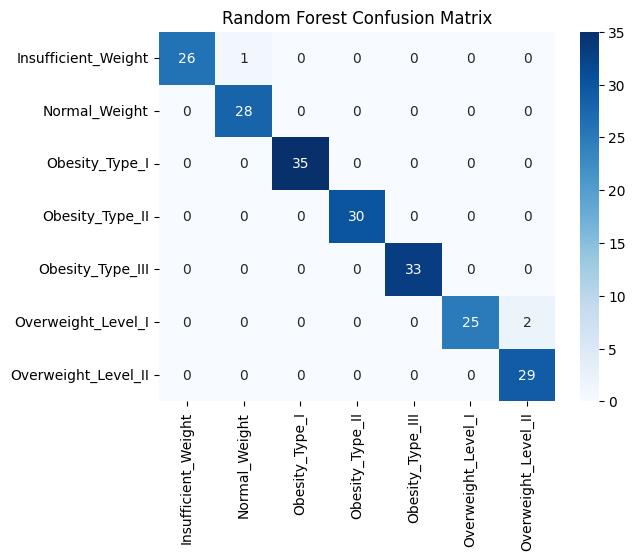

Random Forest: 
Accuracy: 0.9856
Precision: 0.9864
Recall: 0.9856
F1-Score: 0.9856





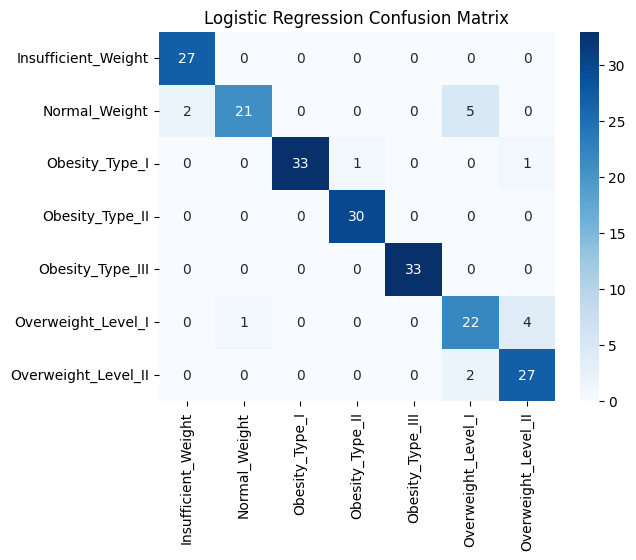

Logistic Regression: 
Accuracy: 0.9234
Precision: 0.9275
Recall: 0.9234
F1-Score: 0.9231





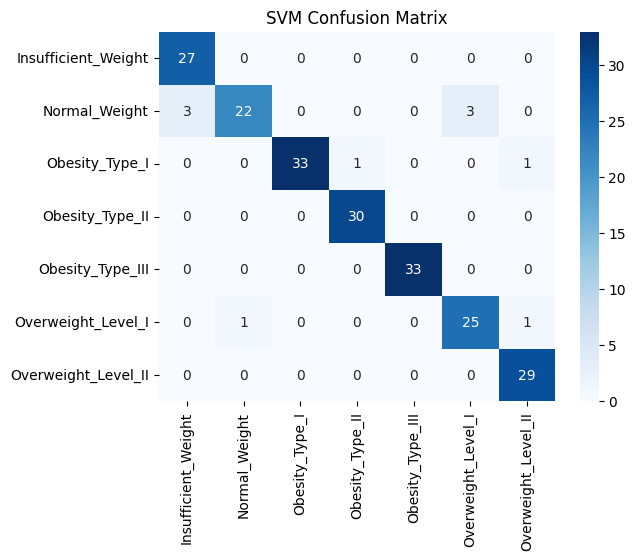

SVM: 
Accuracy: 0.9522
Precision: 0.9538
Recall: 0.9522
F1-Score: 0.9512





In [11]:

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM": SVC(random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(train_df.drop(columns=['NObeyesdad']), train_df['NObeyesdad'])
    y_pred_val = model.predict(val_df.drop(columns=['NObeyesdad']))
    
    results[name] = {
        "Accuracy": accuracy_score(val_df['NObeyesdad'], y_pred_val),
        "Precision": precision_score(val_df['NObeyesdad'], y_pred_val, average='weighted'),
        "Recall": recall_score(val_df['NObeyesdad'], y_pred_val, average='weighted'),
        "F1-Score": f1_score(val_df['NObeyesdad'], y_pred_val, average='weighted'),
        "Confusion Matrix": confusion_matrix(val_df['NObeyesdad'], y_pred_val),
    }

    # Grafica la matriz de confusión de cada modelo
    sns.heatmap(results[name]["Confusion Matrix"], annot=True, fmt="d", cmap="Blues",
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
    # Muestra la evaluación de cada modelo
    print(f'{name}: ')
    print(f'Accuracy: {results[name]['Accuracy']:.4f}')
    print(f'Precision: {results[name]['Precision']:.4f}')
    print(f'Recall: {results[name]['Recall']:.4f}')
    print(f'F1-Score: {results[name]['F1-Score']:.4f}')
    print('\n\n')
    

## 🔹 Paso 8: Tuning de Hiperparámetros (Random Forest)

In [12]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(train_df.drop(columns=['NObeyesdad']), train_df['NObeyesdad'])

best_rf_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


## 🔹 Paso 9: Evaluación Final en Test Set

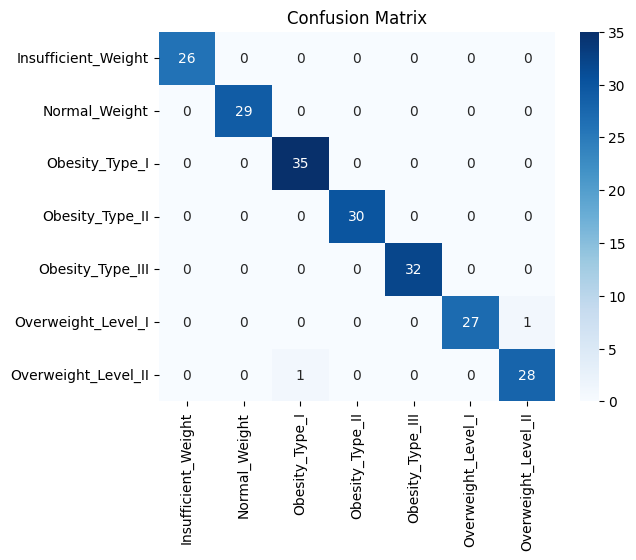

Accuracy: 0.9904
Precision: 0.9906
Recall: 0.9904
F1-Score: 0.9904


In [13]:

y_pred_test = best_rf_model.predict(test_df.drop(columns=['NObeyesdad']))
test_accuracy = accuracy_score(test_df['NObeyesdad'], y_pred_test)
test_precision = precision_score(test_df['NObeyesdad'], y_pred_test, average='weighted')
test_recall = recall_score(test_df['NObeyesdad'], y_pred_test, average='weighted')
test_f1 = f1_score(test_df['NObeyesdad'], y_pred_test, average='weighted')


test_confusion_matrix = confusion_matrix(test_df['NObeyesdad'], y_pred_test)


sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")


In [14]:
importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame({'feature': train_df.drop(columns=['NObeyesdad']).columns, 'importance': importances})
importance_df.sort_values(by='importance', ascending=False).head(10)

,feature,importance
8,BMI,0.453569
2,Weight,0.189164
9,Weight_Age_Ratio,0.072893
3,FCVC,0.069114
1,Height,0.063375
0,Age,0.057318
4,NCP,0.027587
6,FAF,0.018559
5,CH2O,0.017636
7,TUE,0.017178


In [15]:
import joblib
joblib.dump(best_rf_model, 'modelo_rf.pkl') # Guarda el modelo de clasificacion
joblib.dump(scaler, 'scaler.pkl') # Guarda el escalador de los datos numericos
joblib.dump(encoder, 'encoder.pkl') # Guarda el codificador de las categorias de Obesidad

['encoder.pkl']

In [16]:
import gradio as gr
import numpy as np
import joblib
import ollama  

MODELO = 'mistral'

# Cargar modelo de lenguaje local
ollama.pull(MODELO)

# Cargar modelo, scaler y encoder
model = joblib.load("modelo_rf.pkl")
scaler = joblib.load("scaler.pkl")
encoder = joblib.load("encoder.pkl")

# Diccionario de traducción
TRADUCCION_CLASES = {
    "Insufficient_Weight": "Peso insuficiente",
    "Normal_Weight": "Peso normal",
    "Overweight_Level_I": "Sobrepeso nivel I",
    "Overweight_Level_II": "Sobrepeso nivel II",
    "Obesity_Type_I": "Obesidad tipo I",
    "Obesity_Type_II": "Obesidad tipo II",
    "Obesity_Type_III": "Obesidad tipo III"
}

# Función para generar el prompt para Ollama
def generar_prompt(datos, clasificacion):
    prompt = f"""
Eres un asistente en nutrición y salud. El siguiente es el perfil de un paciente, incluyendo datos antropométricos y hábitos. Con base en esto, proporciona:
1. Un análisis breve de su estado de salud.
2. Una recomendación personalizada para mejorar su salud.
3. Consejos adaptados a su estilo de vida.

Datos del paciente:
- Edad: {datos['Age']} años
- Estatura: {datos['Height']} m
- Peso: {datos['Weight']} kg
- Frecuencia de consumo de vegetales (FCVC) de 0-3: {datos['FCVC']}
- Número de comidas diarias (NCP): {datos['NCP']}
- Consumo diario de agua (CH2O) de 0-3: {datos['CH2O']}
- Nivel de actividad física (FAF) de 0-3: {datos['FAF']}
- Horas frente a pantallas (TUE) de 0-2: {datos['TUE']}

Resultado del modelo de clasificación: **{clasificacion}**

Sé empático, claro y usa lenguaje sencillo. Utiliza lenguaje español latino en todo momento. Escribe la recomendación en tercera persona.

"""
    return prompt

# Función principal
def predecir_obesidad(Age, Height, Weight, FCVC, NCP, CH2O, FAF, TUE):
    # Variables derivadas
    BMI = Weight / (Height ** 2)
    Weight_Age_Ratio = Weight / Age
    FAF_TUE_Interaction = FAF * TUE

    # Preprocesamiento
    features = np.array([[Age, Height, Weight, FCVC, NCP, CH2O, FAF, TUE,
                          BMI, Weight_Age_Ratio, FAF_TUE_Interaction]])
    features_scaled = scaler.transform(features)

    # Predicción
    prediction = model.predict(features_scaled)
    clase = encoder.inverse_transform(prediction)[0]
    clase_es = TRADUCCION_CLASES.get(clase, "Clasificación desconocida")

    # Generar prompt para LLM
    datos_usuario = {
        "Age": Age, "Height": Height, "Weight": Weight,
        "FCVC": FCVC, "NCP": NCP, "CH2O": CH2O,
        "FAF": FAF, "TUE": TUE
    }
    prompt = generar_prompt(datos_usuario, clase_es)

    # Llamar al modelo local con Ollama
    respuesta_llm = ollama.chat(
        model=MODELO,  # puedes usar "llama2" o el modelo que tengas disponible
        messages=[{"role": "user", "content": prompt}]
    )["message"]["content"]

    # Retornar clasificación + recomendación
    resultado = f"📊 Clasificación: {clase_es}\n\n🧠 Recomendación personalizada:\n{respuesta_llm}"
    return resultado

# Interfaz Gradio
interface = gr.Interface(
    fn=predecir_obesidad,
    inputs=[
        gr.Number(label="Edad"),
        gr.Number(label="Estatura (m)"),
        gr.Number(label="Peso (kg)"),
        gr.Slider(1, 3, step=0.1, label="Frecuencia de consumo de vegetales (FCVC)"),
        gr.Slider(1, 4, step=1, label="Número de comidas (NCP)"),
        gr.Slider(1, 3, step=0.1, label="Consumo de agua (CH2O)"),
        gr.Slider(0, 3, step=0.1, label="Actividad física (FAF)"),
        gr.Slider(0, 2, step=0.1, label="Uso de tecnología (TUE)")
    ],
    outputs="text",
    title="Clasificador de Obesidad con Recomendación Personalizada",
    description="Ingresa tus datos para obtener tu clasificación de obesidad y una recomendación personalizada."
)

interface.launch(share=True) # share=True genera un enlace para compartir

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://fd9a7e77d4973ac5ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.1